SpM
=============

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import sys
sys.path.append("../src/")

In [5]:
from admmsolver.objectivefunc import LeastSquares, L1Regularizer, NonNegativePenalty
from admmsolver.optimizer import SimpleOptimizer, Problem
from admmsolver.matrix import identity, DiagonalMatrix
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import irbasis3

In [6]:
wmax = 10.0
beta = 100.0
lambda_ = wmax * beta
K = irbasis3.KernelFFlat(lambda_)
basis = irbasis3.FiniteTempBasis(K, "F", beta, eps=1e-15)

(1.0, 1.4502724144109698e-08)


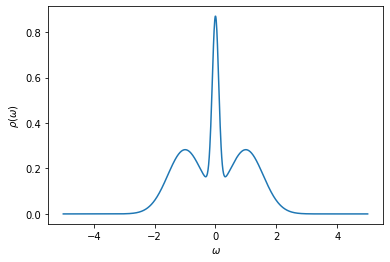

In [7]:
gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

from scipy.integrate import quad
print(quad(rho, -10, 10))

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.plot(omegas, rho(omegas))

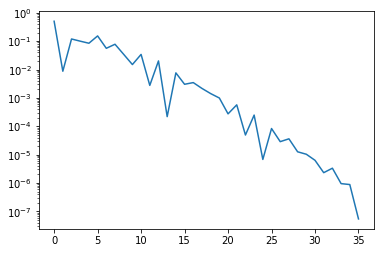

In [8]:
# Expand the spectral function in IR
from numpy.polynomial.legendre import leggauss

def scale_quad(x, w, xmin, xmax):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

x_, w_ = leggauss(10000)
x, w = scale_quad(x_, w_, -wmax, wmax)
all_l = np.arange(basis.s.size)

rhol = np.einsum('lw,w,w->l', basis.v.value(all_l[:,None], x[None,:]), w, rho(x), optimize=True)
gl = - basis.s * rhol

plt.semilogy(np.abs(rhol)[::2])

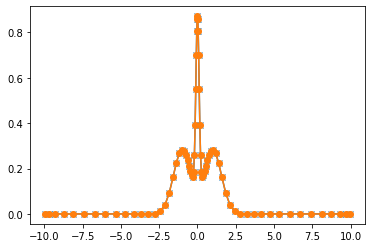

In [38]:
smpl_w = basis.v[-1].roots()
prj_w = basis.v(smpl_w).T

plt.plot(smpl_w, rho(smpl_w), marker="x")
plt.plot(smpl_w, prj_w @ rhol, marker="o")

In [69]:
# rho_l = argmin_{x} |- s_l * x_l + g_l|_2^2 + alpha * |x|_1
alpha = 1e-4

lstsq = LeastSquares(1.0, -DiagonalMatrix(basis.s), gl)
l1 = L1Regularizer(alpha, basis.size)
nn = NonNegativePenalty(prj_w.shape[0])

equality_conditions = [
      (0, 1, identity(basis.size), identity(basis.size)),
      (0, 2, prj_w, identity(prj_w.shape[0]))
]
problem = Problem([lstsq, l1, nn], equality_conditions)

In [78]:
x0 = None
#x0 = problem.num_func * [rhol]
opt = SimpleOptimizer(problem, x0=x0, mu=1.0)
opt.solve(10000)
#print(lstsq(opt.x[0]) + l1(opt.x[0]))
#print(lstsq(rhol) + l1(rhol))

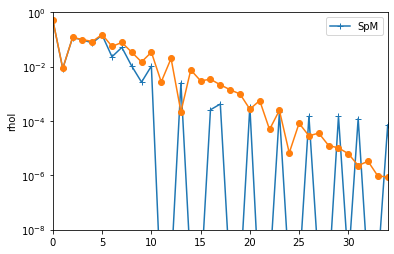

In [79]:
plt.semilogy(np.abs(opt.x[0][::2].real), marker="+", label="SpM")
plt.semilogy(np.abs(rhol[::2]), marker="o")
plt.xlim([0,34])
plt.ylim([1e-8,1])
plt.ylabel("rhol")
plt.legend()

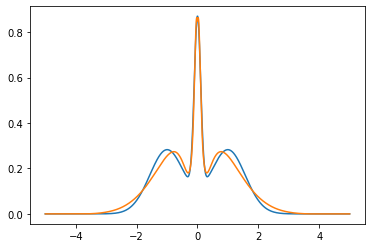

In [80]:
plt.plot(omegas, rho(omegas))
plt.plot(omegas, (basis.v(omegas).T @ opt.x[0]).real)